In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import numpy as np
import time
import pandas as pd
import pickle

import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch.utils.data import DataLoader
from torch import nn, optim
from torch.nn import functional as F

from structure.data import HMM_Data
from structure.model import ResBlock, ConvBlock, ConvNet, HmmConvNet
from structure.utils import *

torch.cuda.is_available()

True

## Build Data

In [35]:
import netsurfp2.preprocess
DATA = "/home/cyril/Documents/These/data/"
DATASET = "luciferase"
FILE = f"{DATA}/{DATASET}/unaligned.fasta"

In [36]:
!rm -r "{DATA}/profilemaker"
!mkdir "{DATA}/profilemaker"
!mkdir "{DATA}/profilemaker/mmseqs_files"
!cp "{FILE}" "{DATA}/profilemaker/mmseqs_files/in.fasta"
!mmseqs createdb "{DATA}/profilemaker/mmseqs_files/in.fasta" "{DATA}/profilemaker/mmseqs_files/in.mmdb"

Converting sequences
[44643] 0s 39ms
Time for merging to in.mmdb_h: 0h 0m 0s 11ms
Time for merging to in.mmdb: 0h 0m 0s 33ms
Database type: Aminoacid
Time for merging to in.mmdb.lookup: 0h 0m 0s 0ms
Time for processing: 0h 0m 0s 129ms


In [37]:
import netsurfp2 as nsp2
with open(f"{DATA}/profilemaker/mmseqs_files/in.fasta") as f:
    protlist = nsp2.parse_fasta(f)
protlist = {k:v for k,v in random.sample(protlist.items(), 100)}
searcher = netsurfp2.preprocess.MMseqs(f"{DATA}/profilemaker/mmseqs_files/in.mmdb") #Specifies hhblits as model
profiles  = searcher(protlist, f"{DATA}/profilemaker/")
dataset = {k:v["profile"] for k,v in profiles.items()}
pickle.dump(dataset, open(f"{DATA}/{DATASET}/hmm_dataset", "wb"))

KeyboardInterrupt: 

In [16]:
!rm -r "{DATA}/profilemaker"

## Data and Model

In [4]:
AMINO_ACIDS = 'ACDEFGHIKLMNPQRSTVWY'

In [6]:
DATA = "/home/cyril/Documents/These/data/"
DATASET = "PF00397"

In [7]:
class HMM_Test(object):
    def __init__(self, file):
        self.primary, self.ss3 = [], []
        data = pickle.load(open(file, 'rb'))
        self.primary = [p[:,:50] for p in data.values()]

    def __len__(self):
        return len(self.primary)
    
    def __getitem__(self, i):
        return self.primary[i]

In [ ]:
full_dataset = HMM_Data(f"{DATA}/secondary_structure/full_set")
full_loader = DataLoader(full_dataset, batch_size = 1, 
                        shuffle = True, drop_last=True)

In [8]:
train_dataset = HMM_Data(f"{DATA}/secondary_structure/training_set")
train_loader = DataLoader(train_dataset, batch_size = 1, 
                        shuffle = True, drop_last=True)

In [9]:
val_dataset = HMM_Data(f"{DATA}/secondary_structure/validation_set")
val_loader = DataLoader(val_dataset, batch_size = 1,
                        shuffle=False, drop_last=False)

In [8]:
test_dataset = HMM_Test(f"{DATA}/{DATASET}/hmm.pkl")
test_loader = DataLoader(test_dataset, batch_size = 1,
                        shuffle=False, drop_last=False)

In [24]:
class RecurrentSequenceDecoder(nn.Module):
    def __init__(self, q = 21, ncell=512,
                               project_x=True, input_dropout=nn.Identity):
        super(RecurrentSequenceDecoder, self).__init__()
        self.q = q
        
        self.dropout1 = input_dropout()
        if project_x:
            self.project = nn.Conv1d(q, q, kernel_size = 1)
        self.gru = nn.GRU(q, ncell)
        self.ss3 = nn.Conv1d(ncell, 3, 1)
        self.ss8 = nn.Conv1d(ncell, 8, 1)
        self.other = nn.Conv1d(ncell, 9, 1)


            
    def forward(self, x):
        x = x[:,:self.q]
        x = F.pad(x,(1,0))[:,:,:-1]
        x = self.dropout1(x)
        if self.project is not None:
            x = self.project(x)            
        h = x.permute(2,0,1)
        h = self.gru(h)[0].permute(1,2,0)
        return F.relu(self.other(h)), F.softmax(self.ss8(h),1), F.softmax(self.ss3(h),1)


In [30]:
qx = 40
# del model
device = torch.device('cuda')

# del model
model = RecurrentSequenceDecoder(qx)
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
# model.load_state_dict(torch.load(f"{DATA}/secondary_structure/model_40feats.h5"))
start = time.time()

model

RecurrentSequenceDecoder(
  (dropout1): Identity()
  (project): Conv1d(40, 40, kernel_size=(1,), stride=(1,))
  (gru): GRU(40, 512)
  (ss3): Conv1d(512, 3, kernel_size=(1,), stride=(1,))
  (ss8): Conv1d(512, 8, kernel_size=(1,), stride=(1,))
  (other): Conv1d(512, 9, kernel_size=(1,), stride=(1,))
)

## Train

In [29]:
def train(epoch):
    n_res, mean_ss3, mean_ss8, mean_box, mean_other, mean_loss, mean_ss3_acc, mean_ss8_acc = 0,0,0,0,0,0,0,0
    model.train()
    for batch_idx, data in enumerate(train_loader):
        x = data[0].float().permute(0, 2, 1).cuda()[:,:40]
        s = data[1].float().permute(0, 2, 1).cuda()
        t = data[2].float().permute(0, 2, 1).cuda()
        B,_,N = x.size()

        optimizer.zero_grad()
        p_other, p_ss8, p_ss3 = model(x)
        p_other, p_ss8, p_ss3 = p_other.cpu(), p_ss8.cpu(), p_ss3.cpu()
        x, s, t = x.cpu(), s.cpu(), t.cpu()
        
        ss3_acc = (p_ss3.argmax(1) == t[:,-1]).int().float().mean()
        ss8_acc = (p_ss8.argmax(1) == t[:,-2]).int().float().mean()
        ss3_loss = F.cross_entropy(p_ss3, t[:,-1].long())
        ss8_loss = F.cross_entropy(p_ss8, t[:,-2].long())
        other_loss = F.mse_loss(p_other, t[:,:9])/1500

        loss = ss3_loss + ss8_loss + other_loss
        loss.backward()
        optimizer.step()
        
        del x; del s;
        mean_ss3 = (mean_ss3*batch_idx + ss3_loss.item())/ (batch_idx+1)
        mean_ss8 = (mean_ss8*batch_idx + ss8_loss.item())/ (batch_idx+1)
        mean_other = (mean_other*batch_idx + other_loss.item())/ (batch_idx+1)
        mean_loss = (mean_loss*batch_idx + loss.item())/ (batch_idx+1)
        mean_ss3_acc = (mean_ss3_acc*n_res + N*ss3_acc.item())/ (n_res+N)
        mean_ss8_acc = (mean_ss8_acc*n_res + N*ss8_acc.item())/ (n_res+N)
        n_res += N
        m, s = int(time.time()-start)//60, int(time.time()-start)%60
        print(f'''Train Epoch: {epoch} [{int(100*batch_idx/len(train_loader))}%] || Time: {m} min {s} || SS3 Acc: {mean_ss3_acc:.3f} || SS8 Acc : {mean_ss8_acc:.3f} || Loss: {mean_loss:.3f} || SS3 Loss: {mean_ss3:.3f} || SS8 Loss: {mean_ss8:.3f} || Other Loss: {mean_other:.3f}'''
              , end="\r")
    m, s = int(time.time()-start)//60, int(time.time()-start)%60
    print(f'''Train Epoch: {epoch} [100%] || Time: {m} min {s}  || SS3 Acc: {mean_ss3_acc:.3f} || SS8 Acc : {mean_ss8_acc:.3f} || Loss: {mean_loss:.3f} || SS3 Loss: {mean_ss3:.3f} || SS8 Loss: {mean_ss8:.3f} || Other Loss: {mean_other:.3f}''')

In [10]:
def train(epoch):
    n_res, mean_ss3, mean_ss8, mean_box, mean_other, mean_loss, mean_ss3_acc, mean_ss8_acc = 0,0,0,0,0,0,0,0
    model.train()
    for batch_idx, data in enumerate(train_loader):
        x = data[0].float().permute(0, 2, 1).cuda()[:,:40]
        s = data[1].float().permute(0, 2, 1).cuda()
        t = data[2].float().permute(0, 2, 1).cuda()
        B,_,N = x.size()

        optimizer.zero_grad()
        p_ss3 = model(x)
        p_ss3 = p_ss3.cpu()
        x, s, t = x.cpu(), s.cpu(), t.cpu()
        
        ss3_acc = (p_ss3.argmax(1) == t[:,-1]).int().float().mean()
        ss3_loss = F.cross_entropy(p_ss3, t[:,-1].long())

        loss = ss3_loss
        loss.backward()
        optimizer.step()
        
        del x; del s;
        mean_loss = (mean_loss*batch_idx + loss.item())/ (batch_idx+1)
        mean_ss3_acc = (mean_ss3_acc*n_res + N*ss3_acc.item())/ (n_res+N)
        n_res += N
        m, s = int(time.time()-start)//60, int(time.time()-start)%60
        print(f'''Train Epoch: {epoch} [{int(100*batch_idx/len(train_loader))}%] || Time: {m} min {s} || SS3 Acc: {mean_ss3_acc:.3f} || Loss: {mean_loss:.3f}'''
              , end="\r")
    m, s = int(time.time()-start)//60, int(time.time()-start)%60
    print(f'''Train Epoch: {epoch} [100%] || Time: {m} min {s}  || SS3 Acc: {mean_ss3_acc:.3f} || Loss: {mean_loss:.3f} ''')

## Validate

In [27]:
import math
def val(epoch, thres = 0.5):
    mean_ss3_acc, mean_ss8_acc, n_res = 0,0,0
    model.eval()
    predictions, predictions2 = [],[]
    for batch_idx, data in enumerate(val_loader):
        if batch_idx == 300:
            break
        x = data[0].float().permute(0, 2, 1).to(device)[:,:40]
        s = data[1].float().permute(0, 2, 1).to(device)
        t = data[2].float().permute(0, 2, 1).to(device)
        B,_,N = x.size()

        optimizer.zero_grad()
        p_other, p_ss8, p_ss3 = model(x)
        p_other, p_ss8, p_ss3 = p_other.cpu(), p_ss8.cpu(), p_ss3.cpu()
        x, s, t = x.cpu(), s.cpu(), t.cpu()
        
        p_ss3 = F.softmax(p_ss3,1)
        p = p_ss3.detach()
        
        predictions.append(p.argmax(1).numpy()[0])
        ss3_acc = (p.argmax(1) == t[:,-1]).int().float().mean()
        ss8_acc = (p_ss8.argmax(1) == t[:,-2]).int().float().mean()
        mean_ss3_acc = (mean_ss3_acc*n_res + N*ss3_acc.item())/ (n_res+N)
        mean_ss8_acc = (mean_ss8_acc*n_res + N*ss8_acc.item())/ (n_res+N)
        n_res += N
        m, s = int(time.time()-start)//60, int(time.time()-start)%60
        print(f'''Val Epoch: {epoch} [{int(100*batch_idx/len(val_loader))}%] || Time: {m} min {s} ||| SS3 Acc: {mean_ss3_acc:.3f} || SS8 Acc: {mean_ss8_acc:.3f}''', end="\r")
    print(f'''Val Epoch: {epoch} [100%] || Time: {m} min {s} || SS3 Acc: {mean_ss3_acc:.3f} || SS8 Acc: {mean_ss8_acc:.3f}''')
    return predictions, predictions2

In [ ]:
import math
def val(epoch, thres = 0.5):
    mean_ss3_acc, mean_ss8_acc, n_res = 0,0,0
    model.eval()
    predictions = []
    for batch_idx, data in enumerate(val_loader):
        if batch_idx == 300:
            break
        x = data[0].float().permute(0, 2, 1).to(device)[:,:40]
        s = data[1].float().permute(0, 2, 1).to(device)
        t = data[2].float().permute(0, 2, 1).to(device)
        B,_,N = x.size()

        optimizer.zero_grad()
        p_ss3 = model(x)
        p_ss3 = p_ss3.cpu()
        x, s, t = x.cpu(), s.cpu(), t.cpu()
        
        predictions.append(p_ss3.argmax(1).numpy()[0])
        ss3_acc = (p_ss3.argmax(1) == t[:,-1]).int().float().mean()
        mean_ss3_acc = (mean_ss3_acc*n_res + N*ss3_acc.item())/ (n_res+N)
        n_res += N
        m, s = int(time.time()-start)//60, int(time.time()-start)%60
        print(f'''Val Epoch: {epoch} [{int(100*batch_idx/len(val_loader))}%] || Time: {m} min {s} ||| SS3 Acc: {mean_ss3_acc:.3f}''', end="\r")
    print(f'''Val Epoch: {epoch} [100%] || Time: {m} min {s} || SS3 Acc: {mean_ss3_acc:.3f}''')
    return predictions

### Run

In [31]:
for i in range(50):
    train(i)
    val(i)

Train Epoch: 0 [100%] || Time: 4 min 47  || SS3 Acc: 0.523 || SS8 Acc : 0.397 || Loss: 5.075 || SS3 Loss: 1.006 || SS8 Loss: 1.860 || Other Loss: 2.210
Val Epoch: 0 [100%] || Time: 4 min 51 || SS3 Acc: 0.529 || SS8 Acc: 0.448
Train Epoch: 1 [100%] || Time: 10 min 31  || SS3 Acc: 0.573 || SS8 Acc : 0.464 || Loss: 4.398 || SS3 Loss: 0.957 || SS8 Loss: 1.791 || Other Loss: 1.649
Val Epoch: 1 [100%] || Time: 10 min 35 || SS3 Acc: 0.588 || SS8 Acc: 0.464
Train Epoch: 2 [100%] || Time: 16 min 28  || SS3 Acc: 0.591 || SS8 Acc : 0.477 || Loss: 4.351 || SS3 Loss: 0.939 || SS8 Loss: 1.778 || Other Loss: 1.634
Val Epoch: 2 [100%] || Time: 16 min 33 || SS3 Acc: 0.593 || SS8 Acc: 0.471
Train Epoch: 3 [100%] || Time: 22 min 44  || SS3 Acc: 0.601 || SS8 Acc : 0.488 || Loss: 4.318 || SS3 Loss: 0.929 || SS8 Loss: 1.767 || Other Loss: 1.622
Val Epoch: 3 [100%] || Time: 22 min 48 || SS3 Acc: 0.607 || SS8 Acc: 0.485


KeyboardInterrupt: 

In [15]:
torch.save(model.state_dict(), f"{DATA}/secondary_structure/model_nofeats.h5")

## Test/Use

In [8]:
def test(epoch, thres = 0.5):
    mean_ss3_acc, mean_ss8_acc, n_res = 0,0,0
    model.eval()
#     denoiser.eval()
    predictions = []
    for batch_idx, data in enumerate(test_loader):
#         if batch_idx == 300:
#             break
        x = data.float().permute(0, 2, 1).to(device)[:,:40]
        B,_,N = x.size()

        optimizer.zero_grad()
        p_other, p_ss8, p_ss3 = model(x)
        p_other, p_ss8, p_ss3 = p_other.cpu(), p_ss8.cpu(), p_ss3.cpu()
        x = x.cpu()
        
        p_ss3 = F.softmax(p_ss3,1)
        p_ss8 = F.softmax(p_ss8,1)
        predictions.append(p_ss3[0].permute(1,0).detach().numpy())

    return predictions

In [9]:
potentials = test(0)

In [13]:
len(potentials)

54025

## Vizualize

In [23]:
colors = [(0.7,0.2,0), 
          (0.7,0.2,0.4), 
          (0.7,0.2,0.8), 
          (0,1,0), 
          (0.7,1,0), 
          (0,0,1), 
          (0,0.4,1), 
          (0,0.8,1)]

def to_seq(p, size):
    seq = np.ones(size, dtype = int)*2
    for bbox in p.numpy().T[::-1]:
        seq[bbox[0]: bbox[1]] = bbox[2]
    return seq

def overlap_to_one(x, p):
    x = x.expand(x.size(0), p.size(-1))
    inter_low = torch.max(x[0], p[0]).float()
    inter_high = torch.min(x[1], p[1]).float()
    union_low = torch.min(x[0], p[0]).float()
    union_high = torch.max(x[1], p[1]).float()
    return torch.clamp((inter_high - inter_low),min = 0)

def to_map(pot, k):
    mapping = np.ones((pot.shape[0],3))
    r,g,b = colors[k]
    p = pot[:,k]
    mapping[:,0] = r*p
    mapping[:,1] = g*p
    mapping[:,2] = b*p
    return mapping

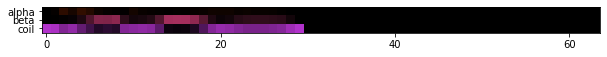

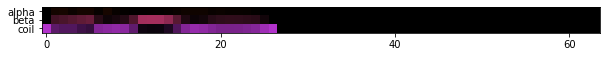

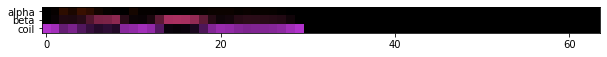

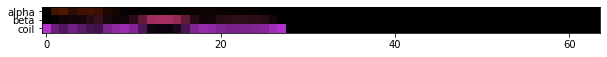

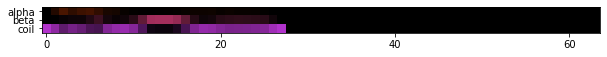

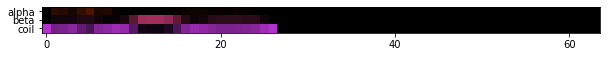

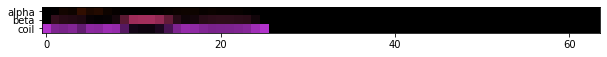

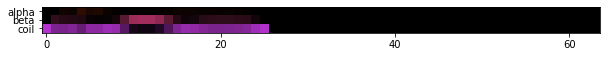

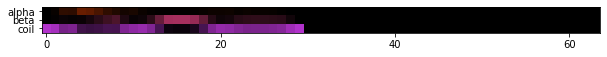

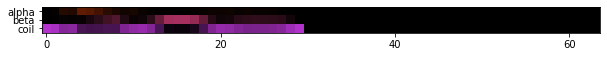

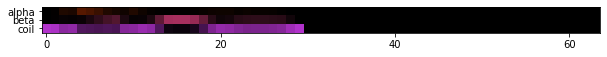

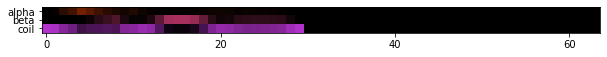

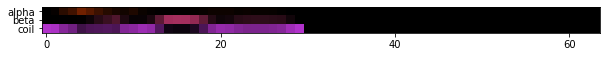

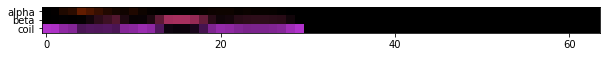

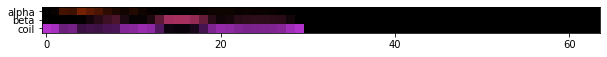

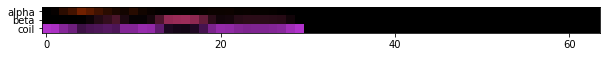

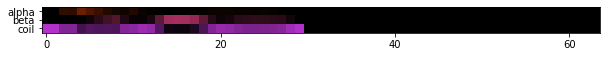

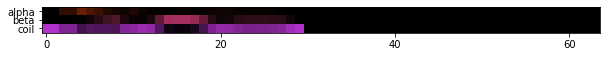

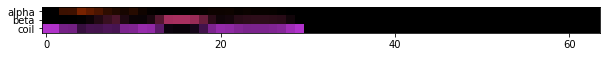

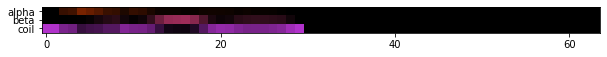

In [26]:
SIZE = 64

for i in range(20):
#     gt = np.array(val_dataset[i][2][:,-1],dtype=int)
    N = potentials[i].shape[0]
    q, r = N//SIZE, N%SIZE
    j = 0
    for j in range(q):
        fig = plt.figure(figsize=(10,3))
        p = potentials[i][SIZE*j:SIZE*(j+1)]
        mapping = np.array([to_map(p,i) for i in range(3)])
        plt.xticks(list(range(0,SIZE,20)), list(range(SIZE*j,SIZE*(j+1),20)))
        plt.yticks([0,1,2],["alpha", "beta", "coil"])
        plt.imshow(mapping)

    fig = plt.figure(figsize=(10,3))
    p = np.pad(potentials[i][-r:], ((0,SIZE-r),(0,0)))
    mapping = np.array([to_map(p,i) for i in range(3)])
    plt.xticks(list(range(0,SIZE,20)), list(range(SIZE*j,SIZE*(j+1),20)))
    plt.yticks([0,1,2],["alpha", "beta", "coil"])
    plt.imshow(mapping)


In [10]:
pickle.dump(potentials, open(f"{DATA}/{DATASET}/ss3_spec.pkl", "wb"))

In [17]:
len(potentials)

54025

## Denoiser

In [149]:
from secondary_structure.model import ResBlock, leaky_relu, ConvBlock

class Denoiser(nn.Module):
    def __init__(self):
        super(Denoiser, self).__init__()

        self.conv1 = ConvBlock(nn.Conv1d, None, None, 
                                3, 3, 257,
                                stride=1, padding=128, bias=True)
#         self.conv2 = ConvBlock(nn.Conv1d, leaky_relu, nn.BatchNorm1d, 
#                                 32, 64, 129,
#                                 stride=1, padding=64, bias=True)  
#         self.conv3 = ConvBlock(nn.Conv1d, leaky_relu, nn.BatchNorm1d, 
#                         64, 3, 129,
#                         stride=1, padding=64, bias=True)        

        

    def forward(self, x):
        h = self.conv1(x)
#         h = self.conv2(h)
#         h = self.conv3(h)
        return h

In [150]:
def seq_acc(pred, target):
    return (pred.argmax(1) == target).sum()

def train_denoiser(epoch):
    start = time.time()
    denoiser.train()
    train_loss, train_acc, n_res = 0, 0, 0
    for batch_idx, data in enumerate(train_loader):
        t = data[2].float().permute(0, 2, 1)[:, -1].long()
        B,N = t.size()
        
        x = t.clone().view(1,1,-1)
        perm = torch.randperm(N)
        idx = perm[:N//10]
        changes = torch.randint(2, size = (N//10,))
        x[0,0,idx] = changes
        x_onehot = torch.zeros(B,3,N)
        x_onehot[0, x[0,0], torch.arange(N)] = 1
        
        optimizer.zero_grad()
        y = denoiser(x_onehot.cuda()).cpu()
        loss = F.cross_entropy(y, t)
        loss.backward()
        train_loss += loss.item()/len(data)
        optimizer.step()
        
        acc = seq_acc(y, t).float()
        train_acc = (train_acc * n_res + acc)/(n_res+N)
        n_res += N
        print(f'''Train Epoch: {epoch} [{100. * batch_idx / len(train_loader):.0f}%] || Loss: {train_loss/(batch_idx+1):.2f} || Time: {time.time()-start:.2f}s || Acc: {train_acc:.4f}''', end="\r")
        
    print(f'''Train Epoch: {epoch} [100%] || Loss: {train_loss/(batch_idx+1):.2f} || Time: {time.time()-start:.2f}s || Acc: {train_acc:.4f}''')
    
def val_denoiser(epoch):
    start = time.time()
    denoiser.eval()
    val_loss, val_acc, n_res = 0, 0, 0
    for batch_idx, data in enumerate(val_loader):
        t = data[2].float().permute(0, 2, 1)[:, -1].long()
        B,N = t.size()
        
        x = t.clone().view(1,1,-1)
        perm = torch.randperm(N)
        idx = perm[:N//10]
        changes = torch.randint(2, size = (N//10,))
        x[0,0,idx] = changes
        x_onehot = torch.zeros(B,3,N)
        x_onehot[0, x[0,0], torch.arange(N)] = 1
                
        y = denoiser(x_onehot.cuda()).cpu()
        loss = F.cross_entropy(y, t)

        val_loss += loss.item()/len(data)
        acc = seq_acc(y, t).float()
        val_acc = (val_acc * n_res + acc)/(n_res+N)
        n_res += N
    print(f'''Val Epoch: {epoch} || Loss: {val_loss/(batch_idx+1):.2f} || Time: {time.time()-start:.2f}s || Acc: {val_acc:.4f}''')


In [153]:
N, qx, qs, h = 128, 50, 3, 8
# del model
device = torch.device('cuda')

# del model
denoiser = Denoiser()
denoiser = denoiser.to(device)
optimizer = optim.Adam(denoiser.parameters(), lr=0.001)
start = time.time()

denoiser

Denoiser(
  (conv1): ConvBlock(
    (conv): Conv1d(3, 3, kernel_size=(257,), stride=(1,), padding=(128,))
  )
)

In [154]:
for i in range(10):
    train_denoiser(i)
    val_denoiser(i)

Train Epoch: 0 [100%] || Loss: 0.04 || Time: 14.07s || Acc: 0.9563
Val Epoch: 0 || Loss: 0.03 || Time: 1.74s || Acc: 0.9703
Train Epoch: 1 [100%] || Loss: 0.03 || Time: 16.24s || Acc: 0.9696
Val Epoch: 1 || Loss: 0.03 || Time: 1.42s || Acc: 0.9690
Train Epoch: 2 [100%] || Loss: 0.03 || Time: 13.09s || Acc: 0.9696
Val Epoch: 2 || Loss: 0.03 || Time: 1.36s || Acc: 0.9692
Train Epoch: 3 [100%] || Loss: 0.03 || Time: 14.10s || Acc: 0.9695
Val Epoch: 3 || Loss: 0.03 || Time: 1.49s || Acc: 0.9704
Train Epoch: 4 [100%] || Loss: 0.03 || Time: 14.78s || Acc: 0.9696
Val Epoch: 4 || Loss: 0.03 || Time: 1.52s || Acc: 0.9693
Train Epoch: 5 [100%] || Loss: 0.03 || Time: 14.07s || Acc: 0.9698
Val Epoch: 5 || Loss: 0.03 || Time: 1.43s || Acc: 0.9700
Train Epoch: 6 [100%] || Loss: 0.03 || Time: 14.43s || Acc: 0.9698
Val Epoch: 6 || Loss: 0.03 || Time: 1.53s || Acc: 0.9698
Train Epoch: 7 [100%] || Loss: 0.03 || Time: 14.21s || Acc: 0.9698
Val Epoch: 7 || Loss: 0.03 || Time: 1.40s || Acc: 0.9700
Train Ep

KeyboardInterrupt: 